In [18]:
import os, json, time
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report ,f1_score
import torch
from PIL import Image
from torchvision import transforms
import timm
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = Path("/kaggle/input/second-model/data_large")   
SAVE_DIR  = Path("/kaggle/working/room_classifier")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists())
print("SAVE_DIR:", SAVE_DIR)


DATA_ROOT exists: True
SAVE_DIR: /kaggle/working/room_classifier


In [4]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".jfif", ".avif"}

def load_items(root: Path):
    items = []
    for letter_dir in root.iterdir():
        if not letter_dir.is_dir():
            continue

        for room_dir in letter_dir.iterdir():
            if not room_dir.is_dir():
                continue

            label = room_dir.name
            for img_path in room_dir.iterdir():
                if img_path.is_file() and img_path.suffix.lower() in IMG_EXTS:
                    items.append((str(img_path), label))
    return items

all_items = load_items(DATA_ROOT)
print("Total images:", len(all_items))
print("Sample:", all_items[:3])



Total images: 14189
Sample: [('/kaggle/input/second-model/data_large/b/Bathroom/000000049183_1.jpg', 'Bathroom'), ('/kaggle/input/second-model/data_large/b/Bathroom/bath_1207_1.jpg', 'Bathroom'), ('/kaggle/input/second-model/data_large/b/Bathroom/000000083738_1.jpg', 'Bathroom')]


In [5]:
labels = sorted(set(lbl for _, lbl in all_items))
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

paths = [p for p, _ in all_items]
y_all = [label2id[lbl] for _, lbl in all_items]

print("Num classes:", len(labels))
print("label2id:", label2id)
print("Counts:", Counter(y_all))


Num classes: 7
label2id: {'Bathroom': 0, 'Bedroom': 1, 'Livingroom': 2, 'dining_room': 3, 'entrance': 4, 'home_office': 5, 'kitchen': 6}
Counts: Counter({1: 3257, 6: 2847, 5: 1873, 2: 1830, 3: 1786, 0: 1488, 4: 1108})


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    paths, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42
)

print("Train:", len(X_train), "Val:", len(X_val))


Train: 11351 Val: 2838


In [7]:
class RoomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, y

In [8]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.65, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08))  
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
train_ds = RoomDataset(X_train, y_train, transform=train_tfms)
val_ds   = RoomDataset(X_val,   y_val,   transform=val_tfms)

In [9]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 355 val batches: 89


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
model = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=len(labels),
    drop_rate=0.2,
    drop_path_rate=0.2
)
model.to(device)

Device: cuda


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [11]:
counts = Counter(y_train)
C = len(labels)
N = len(y_train)
w = np.array([N / (C * counts[c]) for c in range(C)], dtype=np.float32)
class_w = torch.tensor(w, device=device)

criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

/tmp/ipykernel_55/3581818227.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


In [12]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    seen = 0

    all_preds, all_true = [], []

    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                out = model(x)
                loss = criterion(out, y)

            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        seen += bs

        preds = out.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_true.extend(y.detach().cpu().numpy().tolist())

        
        pbar.set_postfix(loss=total_loss/max(seen,1))

    avg_loss = total_loss / seen
    macro_f1 = f1_score(all_true, all_preds, average="macro")  
    return avg_loss, macro_f1


In [13]:
history = {"epoch":[], "train_loss":[], "train_f1":[], "val_loss":[], "val_f1":[], "lr":[]}

best_val_f1 = -1.0
patience = 5
bad = 0
EPOCHS = 20

best_path = SAVE_DIR / "room_classifier_best.pth"
last_path = SAVE_DIR / "room_classifier_last.pth"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()

    tr_loss, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_f1 = run_epoch(val_loader, train=False)

    
    scheduler.step(va_loss)
    lr_now = optimizer.param_groups[0]["lr"]
    dt = time.time() - t0

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_f1"].append(tr_f1)
    history["val_loss"].append(va_loss)
    history["val_f1"].append(va_f1)
    history["lr"].append(lr_now)

    df = pd.DataFrame(history)
    display(df.tail(10))

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} train_f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} val_f1={va_f1:.4f} | "
          f"lr={lr_now:.2e} | {dt:.1f}s")

    torch.save({"model_state": model.state_dict(), "label2id": label2id, "id2label": id2label}, last_path)

   
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        bad = 0
        torch.save({"model_state": model.state_dict(), "label2id": label2id, "id2label": id2label}, best_path)
        print("✅ Saved BEST (val_f1):", best_path.name)
    else:
        bad += 1
        print(f"⏳ No val_f1 improvement. bad={bad}/{patience}")

    if bad >= patience:
        print("🛑 Early stopping triggered.")
        break

print("Best val_f1:", best_val_f1)


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003


Epoch 01 | train_loss=0.8846 train_f1=0.8159 | val_loss=0.7497 val_f1=0.8752 | lr=3.00e-04 | 376.1s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003


Epoch 02 | train_loss=0.7416 train_f1=0.8853 | val_loss=0.7758 val_f1=0.8587 | lr=3.00e-04 | 246.6s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003


Epoch 03 | train_loss=0.7138 train_f1=0.8948 | val_loss=0.7411 val_f1=0.8775 | lr=3.00e-04 | 248.6s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003


Epoch 04 | train_loss=0.7270 train_f1=0.8926 | val_loss=0.8098 val_f1=0.8586 | lr=3.00e-04 | 241.4s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003


Epoch 05 | train_loss=0.7402 train_f1=0.8815 | val_loss=0.7588 val_f1=0.8937 | lr=3.00e-04 | 238.2s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003


Epoch 06 | train_loss=0.6830 train_f1=0.9086 | val_loss=0.6918 val_f1=0.9154 | lr=3.00e-04 | 238.9s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003


Epoch 07 | train_loss=0.6560 train_f1=0.9232 | val_loss=0.6930 val_f1=0.9039 | lr=3.00e-04 | 235.7s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003


Epoch 08 | train_loss=0.6566 train_f1=0.9249 | val_loss=0.6724 val_f1=0.9196 | lr=3.00e-04 | 236.8s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003
8,9,0.665719,0.919323,0.680713,0.923387,0.0003


Epoch 09 | train_loss=0.6657 train_f1=0.9193 | val_loss=0.6807 val_f1=0.9234 | lr=3.00e-04 | 241.0s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
0,1,0.884579,0.815945,0.749746,0.875173,0.0003
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003
8,9,0.665719,0.919323,0.680713,0.923387,0.0003
9,10,0.630678,0.937669,0.668519,0.921590,0.0003


Epoch 10 | train_loss=0.6307 train_f1=0.9377 | val_loss=0.6685 val_f1=0.9216 | lr=3.00e-04 | 241.3s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
1,2,0.741593,0.885282,0.775782,0.858668,0.0003
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003
8,9,0.665719,0.919323,0.680713,0.923387,0.0003
9,10,0.630678,0.937669,0.668519,0.921590,0.0003
10,11,0.632540,0.937067,0.646880,0.929722,0.0003


Epoch 11 | train_loss=0.6325 train_f1=0.9371 | val_loss=0.6469 val_f1=0.9297 | lr=3.00e-04 | 244.5s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
2,3,0.713838,0.894831,0.741127,0.877492,0.0003
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003
8,9,0.665719,0.919323,0.680713,0.923387,0.0003
9,10,0.630678,0.937669,0.668519,0.921590,0.0003
10,11,0.632540,0.937067,0.646880,0.929722,0.0003
11,12,0.622578,0.941206,0.706390,0.890419,0.0003


Epoch 12 | train_loss=0.6226 train_f1=0.9412 | val_loss=0.7064 val_f1=0.8904 | lr=3.00e-04 | 246.9s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
3,4,0.727026,0.892611,0.809775,0.858570,0.0003
4,5,0.740190,0.881516,0.758760,0.893680,0.0003
5,6,0.682963,0.908571,0.691833,0.915440,0.0003
6,7,0.655952,0.923191,0.693041,0.903943,0.0003
7,8,0.656568,0.924905,0.672423,0.919601,0.0003
8,9,0.665719,0.919323,0.680713,0.923387,0.0003
9,10,0.630678,0.937669,0.668519,0.921590,0.0003
10,11,0.632540,0.937067,0.646880,0.929722,0.0003
11,12,0.622578,0.941206,0.706390,0.890419,0.0003
12,13,0.626991,0.938884,0.673198,0.913747,0.0003


Epoch 13 | train_loss=0.6270 train_f1=0.9389 | val_loss=0.6732 val_f1=0.9137 | lr=3.00e-04 | 238.9s
⏳ No val_f1 improvement. bad=2/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
4,5,0.740190,0.881516,0.758760,0.893680,0.00030
5,6,0.682963,0.908571,0.691833,0.915440,0.00030
6,7,0.655952,0.923191,0.693041,0.903943,0.00030
7,8,0.656568,0.924905,0.672423,0.919601,0.00030
8,9,0.665719,0.919323,0.680713,0.923387,0.00030
9,10,0.630678,0.937669,0.668519,0.921590,0.00030
10,11,0.632540,0.937067,0.646880,0.929722,0.00030
11,12,0.622578,0.941206,0.706390,0.890419,0.00030
12,13,0.626991,0.938884,0.673198,0.913747,0.00030
13,14,0.620550,0.940664,0.658157,0.926336,0.00015


Epoch 14 | train_loss=0.6206 train_f1=0.9407 | val_loss=0.6582 val_f1=0.9263 | lr=1.50e-04 | 245.6s
⏳ No val_f1 improvement. bad=3/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
5,6,0.682963,0.908571,0.691833,0.915440,0.00030
6,7,0.655952,0.923191,0.693041,0.903943,0.00030
7,8,0.656568,0.924905,0.672423,0.919601,0.00030
8,9,0.665719,0.919323,0.680713,0.923387,0.00030
9,10,0.630678,0.937669,0.668519,0.921590,0.00030
10,11,0.632540,0.937067,0.646880,0.929722,0.00030
11,12,0.622578,0.941206,0.706390,0.890419,0.00030
12,13,0.626991,0.938884,0.673198,0.913747,0.00030
13,14,0.620550,0.940664,0.658157,0.926336,0.00015
14,15,0.565871,0.967166,0.603107,0.949438,0.00015


Epoch 15 | train_loss=0.5659 train_f1=0.9672 | val_loss=0.6031 val_f1=0.9494 | lr=1.50e-04 | 242.2s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
6,7,0.655952,0.923191,0.693041,0.903943,0.00030
7,8,0.656568,0.924905,0.672423,0.919601,0.00030
8,9,0.665719,0.919323,0.680713,0.923387,0.00030
9,10,0.630678,0.937669,0.668519,0.921590,0.00030
10,11,0.632540,0.937067,0.646880,0.929722,0.00030
11,12,0.622578,0.941206,0.706390,0.890419,0.00030
12,13,0.626991,0.938884,0.673198,0.913747,0.00030
13,14,0.620550,0.940664,0.658157,0.926336,0.00015
14,15,0.565871,0.967166,0.603107,0.949438,0.00015
15,16,0.541768,0.977671,0.659415,0.926295,0.00015


Epoch 16 | train_loss=0.5418 train_f1=0.9777 | val_loss=0.6594 val_f1=0.9263 | lr=1.50e-04 | 242.9s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
7,8,0.656568,0.924905,0.672423,0.919601,0.00030
8,9,0.665719,0.919323,0.680713,0.923387,0.00030
9,10,0.630678,0.937669,0.668519,0.921590,0.00030
10,11,0.632540,0.937067,0.646880,0.929722,0.00030
11,12,0.622578,0.941206,0.706390,0.890419,0.00030
12,13,0.626991,0.938884,0.673198,0.913747,0.00030
13,14,0.620550,0.940664,0.658157,0.926336,0.00015
14,15,0.565871,0.967166,0.603107,0.949438,0.00015
15,16,0.541768,0.977671,0.659415,0.926295,0.00015
16,17,0.540330,0.978065,0.605656,0.952716,0.00015


Epoch 17 | train_loss=0.5403 train_f1=0.9781 | val_loss=0.6057 val_f1=0.9527 | lr=1.50e-04 | 274.9s
✅ Saved BEST (val_f1): room_classifier_best.pth


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
8,9,0.665719,0.919323,0.680713,0.923387,0.000300
9,10,0.630678,0.937669,0.668519,0.921590,0.000300
10,11,0.632540,0.937067,0.646880,0.929722,0.000300
11,12,0.622578,0.941206,0.706390,0.890419,0.000300
12,13,0.626991,0.938884,0.673198,0.913747,0.000300
13,14,0.620550,0.940664,0.658157,0.926336,0.000150
14,15,0.565871,0.967166,0.603107,0.949438,0.000150
15,16,0.541768,0.977671,0.659415,0.926295,0.000150
16,17,0.540330,0.978065,0.605656,0.952716,0.000150
17,18,0.546133,0.974483,0.626052,0.946660,0.000075


Epoch 18 | train_loss=0.5461 train_f1=0.9745 | val_loss=0.6261 val_f1=0.9467 | lr=7.50e-05 | 273.4s
⏳ No val_f1 improvement. bad=1/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
9,10,0.630678,0.937669,0.668519,0.921590,0.000300
10,11,0.632540,0.937067,0.646880,0.929722,0.000300
11,12,0.622578,0.941206,0.706390,0.890419,0.000300
12,13,0.626991,0.938884,0.673198,0.913747,0.000300
13,14,0.620550,0.940664,0.658157,0.926336,0.000150
14,15,0.565871,0.967166,0.603107,0.949438,0.000150
15,16,0.541768,0.977671,0.659415,0.926295,0.000150
16,17,0.540330,0.978065,0.605656,0.952716,0.000150
17,18,0.546133,0.974483,0.626052,0.946660,0.000075
18,19,0.529431,0.983491,0.605545,0.951736,0.000075


Epoch 19 | train_loss=0.5294 train_f1=0.9835 | val_loss=0.6055 val_f1=0.9517 | lr=7.50e-05 | 244.3s
⏳ No val_f1 improvement. bad=2/5


  0%|          | 0/355 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_55/1919044017.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


,epoch,train_loss,train_f1,val_loss,val_f1,lr
10,11,0.632540,0.937067,0.646880,0.929722,0.000300
11,12,0.622578,0.941206,0.706390,0.890419,0.000300
12,13,0.626991,0.938884,0.673198,0.913747,0.000300
13,14,0.620550,0.940664,0.658157,0.926336,0.000150
14,15,0.565871,0.967166,0.603107,0.949438,0.000150
15,16,0.541768,0.977671,0.659415,0.926295,0.000150
16,17,0.540330,0.978065,0.605656,0.952716,0.000150
17,18,0.546133,0.974483,0.626052,0.946660,0.000075
18,19,0.529431,0.983491,0.605545,0.951736,0.000075
19,20,0.520310,0.987871,0.606614,0.949614,0.000075


Epoch 20 | train_loss=0.5203 train_f1=0.9879 | val_loss=0.6066 val_f1=0.9496 | lr=7.50e-05 | 256.4s
⏳ No val_f1 improvement. bad=3/5
Best val_f1: 0.9527160593769335


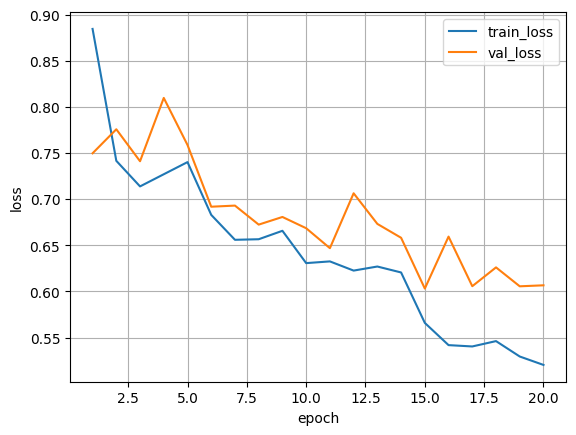

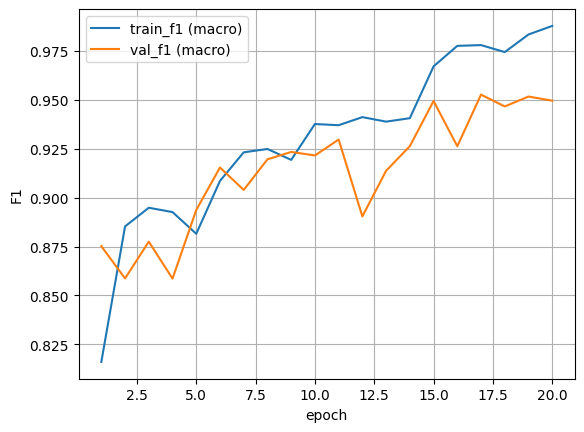

In [14]:
df = pd.DataFrame(history)

plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["epoch"], df["train_f1"], label="train_f1 (macro)")
plt.plot(df["epoch"], df["val_f1"], label="val_f1 (macro)")
plt.xlabel("epoch"); plt.ylabel("F1")
plt.legend(); plt.grid(True)
plt.show()


Macro F1 (main metric): nan
Weighted F1:            nan


Eval:   0%|          | 0/89 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Bathroom     0.9829    0.9631    0.9729       298
     Bedroom     0.9567    0.9493    0.9530       651
  Livingroom     0.8981    0.9153    0.9066       366
 dining_room     0.9566    0.9888    0.9725       357
    entrance     0.9812    0.9414    0.9609       222
 home_office     0.9219    0.9440    0.9328       375
     kitchen     0.9750    0.9613    0.9681       569

    accuracy                         0.9524      2838
   macro avg     0.9532    0.9519    0.9524      2838
weighted avg     0.9529    0.9524    0.9525      2838



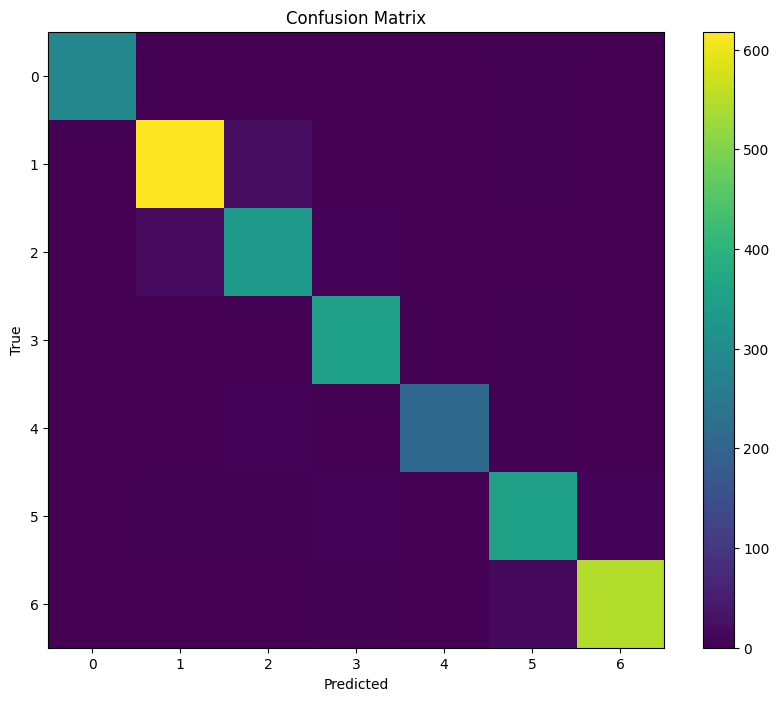

✅ Saved confusion_matrix.png + classification_report.txt in: /kaggle/working/room_classifier


In [15]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

all_preds, all_true = [], []

from sklearn.metrics import f1_score

macro_f1 = f1_score(all_true, all_preds, average="macro")
weighted_f1 = f1_score(all_true, all_preds, average="weighted")

print(f"Macro F1 (main metric): {macro_f1:.4f}")
print(f"Weighted F1:            {weighted_f1:.4f}")


with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Eval"):
        x = x.to(device, non_blocking=True)
        out = model(x)
        pred = out.argmax(1).cpu().numpy()
        all_preds.extend(pred.tolist())
        all_true.extend(y.numpy().tolist())

report = classification_report(all_true, all_preds, target_names=labels, digits=4)
print(report)

with open(SAVE_DIR / "final_metrics.txt", "w") as f:
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.savefig(SAVE_DIR / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved confusion_matrix.png + classification_report.txt in:", SAVE_DIR)

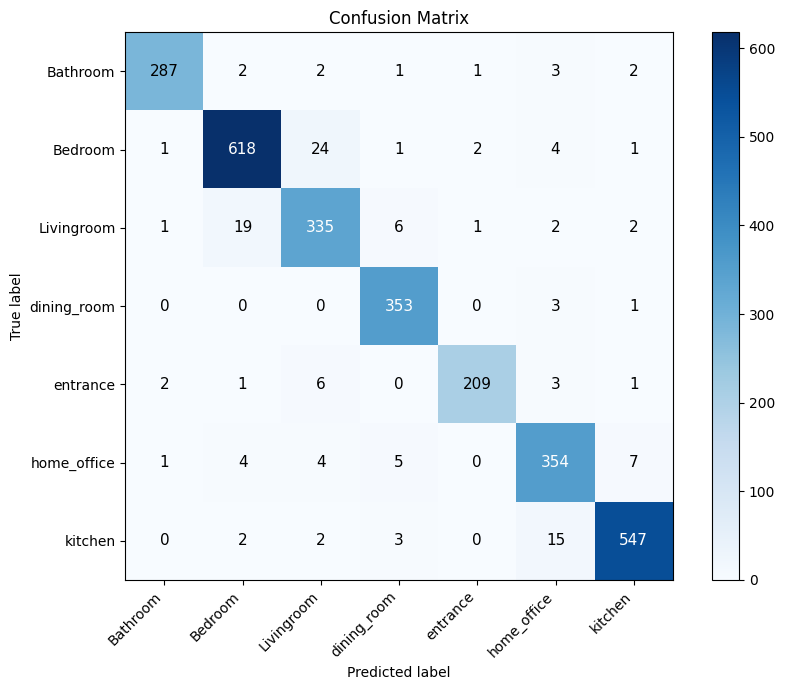

In [16]:
plt.figure(figsize=(9, 7))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)


thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, f"{cm[i, j]}",
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig(SAVE_DIR / "confusion_matrix_numbers.png", dpi=150)
plt.show()

In [17]:
ckpt = {
  "arch": "swin_tiny_patch4_window7_224",
  "img_size": 224,
  "mean": (0.485,0.456,0.406),
  "std":  (0.229,0.224,0.225),
  "label2id": label2id,
  "id2label": id2label,
  "model_state": model.state_dict()
}
torch.save(ckpt, SAVE_DIR / "room_classifier_best.pth")


In [19]:
def load_room_model(ckpt_path, device="cpu"):
    ckpt = torch.load(ckpt_path, map_location=device)
    model = timm.create_model(ckpt["arch"], pretrained=False, num_classes=len(ckpt["label2id"]))
    model.load_state_dict(ckpt["model_state"])
    model.to(device).eval()

    tfm = transforms.Compose([
        transforms.Resize((ckpt["img_size"], ckpt["img_size"])),
        transforms.ToTensor(),
        transforms.Normalize(ckpt["mean"], ckpt["std"])
    ])
    return model, tfm, ckpt["id2label"]

@torch.no_grad()
def predict_room_best(img_pil, model, tfm, id2label, device="cpu"):
    x = tfm(img_pil.convert("RGB")).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]

    best_id = int(torch.argmax(probs).item())
    best_prob = float(probs[best_id].item())

    return {"label": id2label[best_id], "prob": best_prob}



In [20]:
test_path = "/kaggle/input/second-model/data_large/b/Bathroom/000000049183_1.jpg"
img = Image.open(test_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model2, tfm2, id2label2 = load_room_model("/kaggle/working/room_classifier/room_classifier_best.pth", device=device)

result = predict_room_best(img, model2, tfm2, id2label2, device=device)
result = predict_room_best(img, model2, tfm2, id2label2, device=device)

if result["prob"] < 0.60:
    result = {"label": "unknown", "prob": result["prob"]}

print(result)   # {'label': 'kitchen', 'prob': 0.97}



{'label': 'Bathroom', 'prob': 0.9308330416679382}


In [21]:
from pathlib import Path
SAVE_DIR = Path("/kaggle/working")

In [22]:
torch.save(ckpt, SAVE_DIR / "room_classifier_best.pth")
!ls -lah /kaggle/working

total 106M
drwxr-xr-x 4 root root 4.0K Dec 18 08:29 .
drwxr-xr-x 5 root root 4.0K Dec 18 06:53 ..
drwxr-xr-x 2 root root 4.0K Dec 18 08:22 room_classifier
-rw-r--r-- 1 root root 106M Dec 18 08:29 room_classifier_best.pth
drwxr-xr-x 2 root root 4.0K Dec 18 06:53 .virtual_documents
